# Graphical Models: Similarity Distribution Experimentation

In [2]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import random

## Similarity Implementations

### General Methods

In [3]:
# get all children in a dictionary including their respective weights (chains taken into account)
def get_all_children(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_all_children(graph, i[1], children_dict=children_dict, carry=weights[i])
    return children_dict

In [4]:
# (Adapted from function above)
# Get all children in a dictionary including their respective weights (chains taken into account)
def get_descendants(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_descendants(graph, i[1], children_dict=children_dict, carry=weights[i])
    
    return children_dict

In [5]:
# Returns children of a single node
def get_children(gm, parent):
    children_weights = {}
    weights = nx.get_edge_attributes(gm, 'weight')
    
    for i in gm.out_edges(parent):
        children_weights[i[1]] = weights[i]

    return children_weights

In [6]:
def find_node_children_subgraph(graph, snode, childgraph):
    cnodes = graph.neighbors(snode)
    edges = nx.edges(graph)
    for i in cnodes:
        childgraph.add_node(i)
        childgraph.add_edge(snode, i)
        childgraph = find_node_children_subgraph(graph, i, childgraph)
    return childgraph

### Jaccard Index

In [7]:
# all children of rain
def calculate_intersection(graph, children_a, children_b):
    inter = 0
    for i in children_a:
        if i in children_b:
            if children_a[i] < children_b[i]:
                inter += children_a[i]
            else:
                inter += children_b[i]
    return inter  

In [8]:
# helper func to calculate the union using method 1
def calculate_union_1(graph, children_a, children_b):
    union = 0
    for i in children_a:
        union += children_a[i]
    for i in children_b:
        union += children_b[i]
    union -= calculate_intersection(graph, children_a, children_b)
    return union

In [34]:
# calculate the similarity, compares both methods
def calculate_jaccard_similarity(graph, node_a, node_b):
    children_a = get_all_children(graph, node_a, {})
    children_b = get_all_children(graph, node_b, {})
    intersection = calculate_intersection(graph, children_a, children_b)
    union = calculate_union_1(graph, children_a, children_b)
    if union == 0:
        total = 0
    else:
        total = intersection/union
    return total

### Edit-Distance

Edit-distance similarity implementation based only on a node's children.

In [10]:
# Returns the similarity of node B compared to node A, based on 
# children
def get_immediate_similarity(gm, A, B):
    cost = 0.0
    A_children = get_children(gm, A)
    B_children = get_children(gm, B)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    
    return cost / len(A_children)

In [11]:
# Returns the node that is most similar to the input node
def find_most_immediate_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_immediate_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_immediate_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

Edit-distance similarity implementation based on all descendants of a node.

In [12]:
# Returns the similarity of node B compared to node A
def get_full_similarity(gm, A, B):
    cost = 0.0
    A_children = get_descendants(gm, A, {}, 1)
    B_children = get_descendants(gm, B, {}, 1)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    return cost / len(A_children)

# Optional print line in for loop for debugging: 
# print(child, A_children[child], B_children[child])

In [13]:
# Returns the node that is most similar to the input node
def find_most_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_full_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_full_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

### NetworkX: Edit-Distance

In [14]:
# nx.graph_edit_distance(Graph1, Graph2)

### NetworkX: SimRank

In [15]:
# nx.algorithms.similarity.simrank_similarity(graph, source="node_a", target="node_b")

## Generating Random Directed Graphs

In [16]:
def addNodes(gm, num_nodes):
    node_list = []
    
    for i in range(num_nodes):
        gm.add_node(i)

    return gm

In [17]:
def addEdges(gm, num_nodes, num_edges):
    for i in range(num_edges):
        parent = random.randrange(num_nodes)
        child = random.randrange(num_nodes)
        
        while (child == parent):
            child = random.randrange(num_nodes)
        
        conditional_prob = random.uniform(0, 1)
        gm.add_edge(parent, child, weight=conditional_prob)
    
    return gm

In [18]:
def makeDirectedGraph(num_nodes, num_edges):
    dg = nx.DiGraph() # creates directed graph
    dg = addNodes(dg, num_nodes)
    dg = addEdges(dg, num_nodes, num_edges)
    return dg

In [19]:
def makeDirectedPath(num_nodes):
    pdg = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    for i in pdg.edges():
        pdg.edges[i[0], i[1]]['weight'] = weight=random.uniform(0, 1)
    return pdg

def makeDirectedPathOne(num_nodes):
    pdg = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    for i in pdg.edges():
        pdg.edges[i[0], i[1]]['weight'] = 1
    return pdg

In [20]:
def makeDirectedStarGraph(num_nodes):
    sdg = nx.DiGraph()
    sdg.add_node(0)
    for i in range(1, num_nodes+1):
        sdg.add_node(i)
        sdg.add_edge(0, i, weight=random.uniform(0, 1))
    return sdg

## Experiment Setup

### make directed graph

In [21]:
g = makeDirectedGraph(3, 3)

In [22]:
nx.edges(g)

OutEdgeView([(0, 1), (1, 0), (2, 0)])

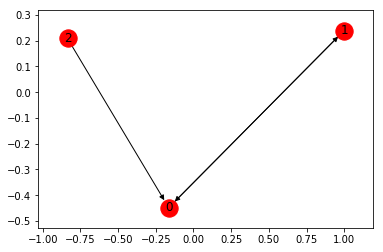

In [23]:
nx.draw_networkx(g)

In [24]:
nx.get_edge_attributes(g, 'weight')

{(0, 1): 0.14540787984964176,
 (1, 0): 0.1460172178772131,
 (2, 0): 0.6016876084561853}

### make directed path

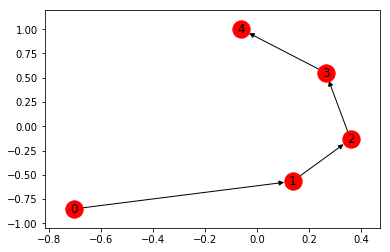

In [25]:
pdg = makeDirectedPath(5)
nx.draw_networkx(pdg)

In [26]:
nx.get_edge_attributes(pdg, 'weight')

{(0, 1): 0.23749084505174733,
 (1, 2): 0.9011869087331753,
 (2, 3): 0.724034079653901,
 (3, 4): 0.7948822843588877}

## Tests
test on paths of length 10, 50, 100, 500, and 1000

In [40]:
pdg = makeDirectedPath(10)
nums = []
for i in pdg.nodes():
    nums.append(calculate_jaccard_similarity(pdg, 0, i))
data = {"10 node graph": nums}

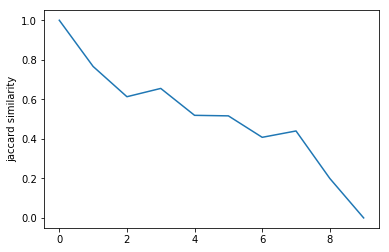

In [41]:
import matplotlib.pyplot as plt
plt.plot(nums)
plt.ylabel("jaccard similarity")
plt.show()

In [42]:
pdg = makeDirectedPath(50)
nums = []
for i in pdg.nodes():
    nums.append(calculate_jaccard_similarity(pdg, 0, i))
data['50 node graph'] = nums

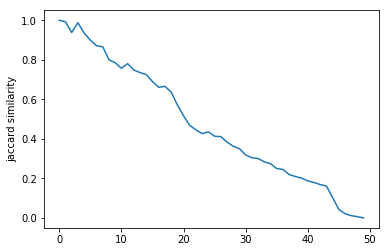

In [43]:
import matplotlib.pyplot as plt
plt.plot(nums)
plt.ylabel("jaccard similarity")
plt.show()

In [44]:
pdg = makeDirectedPath(100)
nums = []
for i in pdg.nodes():
    nums.append(calculate_jaccard_similarity(pdg, 0, i))
data['100 node graph'] = nums

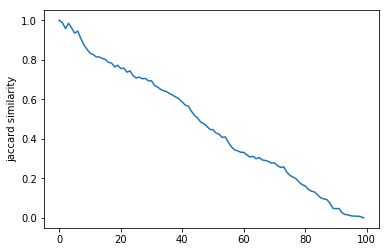

In [45]:
import matplotlib.pyplot as plt
plt.plot(nums)
plt.ylabel("jaccard similarity")
plt.show()

In [46]:
pdg = makeDirectedPath(500)
nums = []
for i in pdg.nodes():
    nums.append(calculate_jaccard_similarity(pdg, 0, i))
data['500 node graph'] = nums

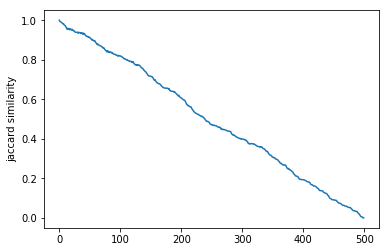

In [47]:
import matplotlib.pyplot as plt
plt.plot(nums)
plt.ylabel("jaccard similarity")
plt.show()

In [48]:
pdg = makeDirectedPath(1000)
nums = []
for i in pdg.nodes():
    nums.append(calculate_jaccard_similarity(pdg, 0, i))
data['1000 node graph'] = nums

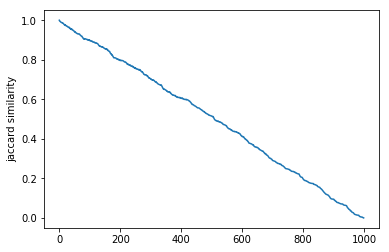

In [49]:
import matplotlib.pyplot as plt
plt.plot(nums)
plt.ylabel("jaccard similarity")
plt.show()

### Export a file to excel

In [52]:
import pandas as pd
df = pd.DataFrame(data, columns = ['10 node graph', '50 node graph', '100 node graph', '500 node graph', '1000 node graph'])
df.to_excel(r'path_tests_file.xlsx', index = False, header=True)

ValueError: arrays must all be same length

In [53]:
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in data.items() })

In [54]:
dict_df

,10 node graph,50 node graph,100 node graph,500 node graph,1000 node graph
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.766260,0.991845,0.987917,0.994007,0.996778
2,0.613103,0.938042,0.958062,0.992258,0.994876
3,0.655110,0.987460,0.984963,0.990032,0.994292
4,0.518987,0.935236,0.960742,0.987987,0.992083
5,0.516273,0.899386,0.934683,0.985288,0.990618
6,0.407740,0.870868,0.945465,0.981595,0.989498
7,0.439875,0.865631,0.908088,0.982051,0.988483
8,0.199516,0.799941,0.875217,0.976592,0.987500
9,0.000000,0.785200,0.853394,0.973889,0.987862


In [55]:
dict_df.to_excel(r'path_tests_file.xlsx', index = False, header=True)

In [51]:
data

{'10 node graph': [0.9999999999999997,
  0.7662603800125318,
  0.6131027313549438,
  0.6551097744683113,
  0.5189872558130293,
  0.5162733233818608,
  0.4077397648381833,
  0.43987516259647724,
  0.1995157400308775,
  0.0],
 '50 node graph': [1.0,
  0.991844766692804,
  0.9380416747962402,
  0.987460234310881,
  0.9352364840386042,
  0.8993857455789868,
  0.8708676499472607,
  0.8656306521629512,
  0.7999411120697629,
  0.7852001496419003,
  0.756882196067493,
  0.7803811275569975,
  0.7481004493863491,
  0.7352069866471035,
  0.7253606059229395,
  0.6899205145298001,
  0.6609657856114184,
  0.6655291575569177,
  0.637450262725929,
  0.5724185244079752,
  0.516525787489302,
  0.46818701466039964,
  0.44570427419125486,
  0.42647158410234054,
  0.435495732625198,
  0.4133406759021884,
  0.41131466071812595,
  0.3839115048482424,
  0.3624712399930411,
  0.35048820897288857,
  0.3186595002151402,
  0.3045231200225989,
  0.30064326698601224,
  0.28380300626929894,
  0.27396896136255394,
  